In [1]:
%pip install py-linq
!python --version
from py_linq import Enumerable
from scipy import constants
from scipy.optimize import fsolve
import math
import matplotlib.pyplot as plt
import numpy as np

Python 3.10.12


In [2]:
def distance(x1, x2, y1, y2):
  res = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
  return res
def intersect(x1, x2, y1, y2, eps):
  if len(x1) != len(y1) or len(x2) != len(y2) or len(x2) != len(x1):
    assert("len x and len y should be equal")

  points = []
  for i in range(len(x1)):
    dist = distance(x1[i], x2[i], y1[i], y2[i])
    if dist <= eps:
      points.append((x1[i], y1[i], dist))

  points = Enumerable(points)
  min_dist = points.select(lambda x: x[2]).min()
  min_point = points.where(lambda x: x[2] == min_dist).first()
  if min_point is None:
    assert('No intersection found')

  return (min_point[0], min_point[1])

Используя уравнение Шредингера, найти связные состояния и соответствующие им собственные значения в случае прямоугольной потенциальной ямы
$V(x) =$
\begin{cases}
    -U & |x| < a\\
    0 & |x| > a
\end{cases}
Найти также собственные функции и собственные значения для осцилляторного потенциала $V(x) = \frac{1}{2}m\omega^2x^2$ Построить графически собственные функции. Рассмотреть случай, когда в точке $x=0$ вводится бесконечно узкая и бесконечная полупроницаемая перегородка. Выявить влияние такой перегородки на стационарные состояния.


In [3]:
from scipy import constants
import math
import matplotlib.pyplot as plt
import numpy as np

a = 2e-10
U = 56.168e-18
omega = 1
m = constants.electron_mass
eps = int(1e7)

def V(x: float) -> float:
  if(abs(x) <= a):
    return -U
  else:
    return 0

def Vo(x: float ) -> float:
  return 1/2 * m * omega ** 2 * x ** 2

x = np.arange(-2 * a, 2 * a, 1e-12)

y = []

for i in range(len(x)):
  y.append(V(x[i]))

In [4]:
k_2 = math.sqrt(2 * m * U) / constants.hbar
lefty = np.arange(0, k_2, eps, dtype=float) * a
leftx = np.arange(0, k_2, eps)
n = math.ceil(k_2 * a / constants.pi)

res = []

for i in range(1, n + 1):
    rightx = []
    righty = []
    for j in range(0, int(k_2), eps):
        rightx.append(j)
        righty.append(constants.pi * i - 2 * math.asin((constants.hbar * j) / math.sqrt(2 * constants.electron_mass * U)))

    point = intersect(leftx, rightx, lefty, righty, eps)
    res.append((point[0], point[1]))


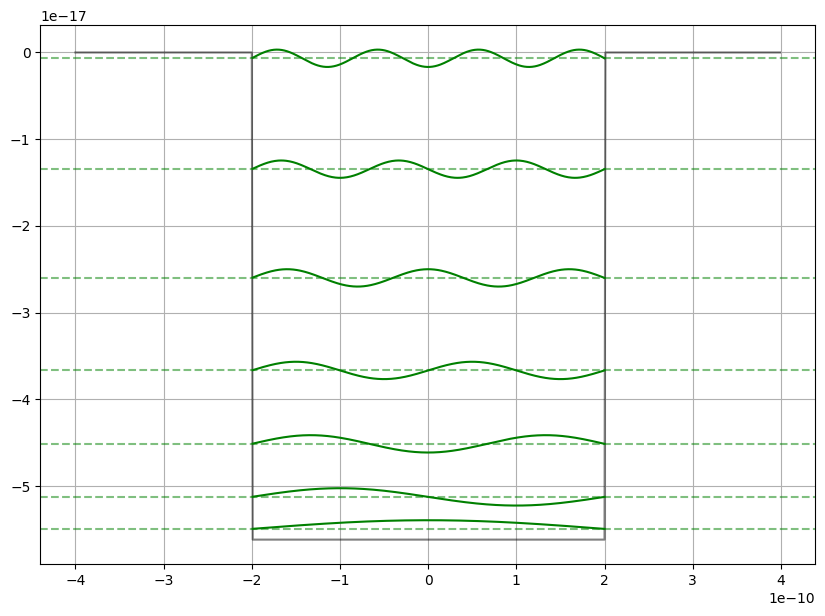

5.55e-17
4.27e-17
3.02e-17
1.95e-17
1.10e-17
4.93e-18
1.23e-18


In [5]:
plt.figure(figsize=(10, 7))
plt.plot(x, y, color = "black", alpha=0.5, linewidth = 1.5)
energy = [0] * len(res)

def psi(x: float, n: int, scale: float = 1e23) -> float:
    if abs(x) > a:
        return 0
    return math.sqrt(2 / a) * math.sin(constants.pi * (n + 1) * (x / (2 * a) + 1 / 2)) / scale

for i in range(len(res)):
    energy[i] = constants.hbar ** 2 * res[i][0] ** 2 / (2 * m)
    plt.axhline(y=energy[i] - U, linestyle="--", c='green', alpha = 0.5)

    y_psi = []
    x_psi = []
    for j in range(len(x)):
        tmp = psi(x[j], i)
        if tmp != 0:
          y_psi.append(tmp + (energy[i] - U))
          x_psi.append(x[j])

    plt.plot(x_psi, y_psi, color='green')
plt.grid()
plt.show()
for i in reversed(energy):
  print(f'{i:.2e}')

In [6]:
def hermite(xi: float, n: int) -> float:
    array = [0] * (n) + [1]
    hermite = np.polynomial.hermite.Hermite(array)
    return hermite(xi)

def psi_osc(x, E: float, n: int):
    points = []
    for i in range(len(x)):
        xi = x[i]*math.sqrt(constants.electron_mass * omega / constants.hbar)
        coef = 1 / (math.sqrt(2 ** n * math.factorial(n))) * (constants.electron_mass * omega / (constants.hbar * constants.pi)) ** 0.25
        point = coef * constants.electron_mass / 15e4 * math.exp(-0.5 * xi ** 2) * hermite(xi, n) + E
        points.append(point)

    return points

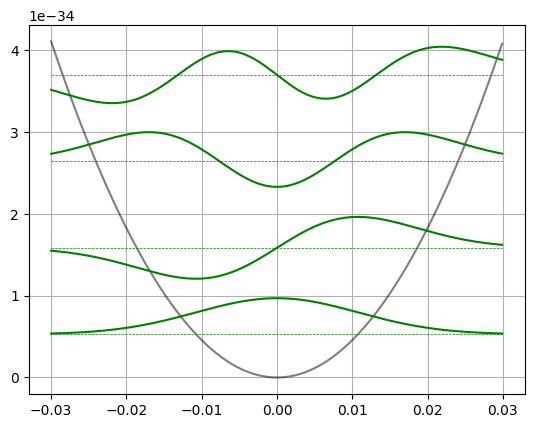

5.27e-35
1.58e-34
2.64e-34
3.69e-34


In [7]:
x2 = np.arange(-0.03, 0.03, 1e-4)
y2 = []

for i in range(len(x2)):
    y2.append(Vo(x2[i]))

plt.plot(x2, y2, c='black', alpha=0.5)

res = []

n = 0
while True:
    E = (n + 0.5) * constants.hbar * omega

    if (E > y2[0]):
        break

    res.append(E)

    plt.plot(x2, [E] * len(x2), linestyle="--", color = 'green', linewidth = 0.5)
    plt.plot(x2, psi_osc(x2, E, n), color = 'green')
    n += 1
plt.grid()
plt.show()
for i in res:
  print(f'{i:.2e}')

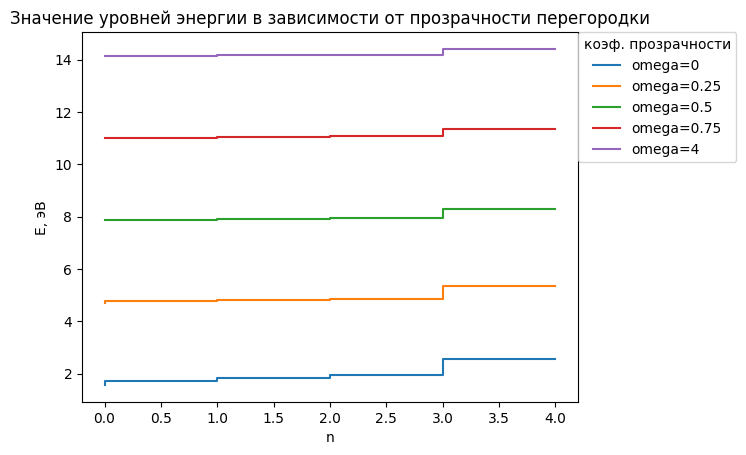

In [8]:
def u2(a, b, x):
    return -1 / np.sqrt(a * (1 - np.sin(2 * b) / (2 * b))) * np.sin(b * np.abs(x) / a - 1)


omega = [0, 1/4, 1 / 2, 3/4, 4]

n = 5

kna = np.zeros((len(omega), n))

for i in range(len(omega)):
    for j in range(n):
        f = lambda k: k / np.tan(k) + omega[i]
        k0 = (j + 0.5) * np.pi
        kna[i, j] = fsolve(f, k0)[0]


for j in range(n):
    b = kna[:, j]
    plt.plot(b, drawstyle='steps-pre', label='omega={}'.format(omega[j]))

plt.title('Значение уровней энергии в зависимости от прозрачности перегородки')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, title='коэф. прозрачности')
plt.xlabel('n')
plt.ylabel('E, эВ')
plt.show()